<a href="https://colab.research.google.com/github/juliosdutra/Controle_de_Processos_UFES/blob/main/4.Closed-Loop/Ex_controladorP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Controle proporcional de um processo de 2a ordem

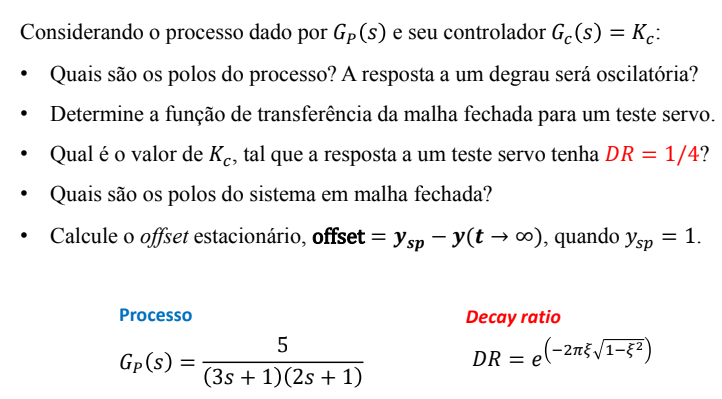

In [1]:
! pip install -qq control

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.1/455.1 kB 7.6 MB/s eta 0:00:00


In [9]:
import numpy as np
import control as ct
import matplotlib.pyplot as plt
import sympy as sp

In [47]:
def calcula_zpk(G):
  z = ct.zero(G) # zeros
  p = ct.pole(G) # polos
  K = ct.dcgain(G) # ganho estacionário
  print('zero = ', z)
  print('polo = ', p)
  print(f'ganho = {K:1.3f}')
  if len(p)<2:
    # apenas para sistemas de primeira ordem
    print(f'constante de tempo = {1/abs(p[0]):1.3f}')

def caracteristica_2ordem(G):
  num, den = ct.tfdata(G) # fornece o numerador e denominador de uma FT
  deng = den[0][0] # representa o denominador (den = a*s**2 + b*s + c)
  tau = np.sqrt(deng[0]/deng[2]) # periodo natural: sqrt(a/c)
  xi = (deng[1]/deng[2])/(2*tau) # fator de amortecimento: (b/c) / (2*tau)
  print(f'Período natural = {tau:1.3f}')
  print(f'Fator de amortecimento = {xi:1.3f}')
  if np.real(xi) < 1.0:
    # apenas para sistemas subamortecidos
    tp = np.pi*tau/np.sqrt(1-xi**2) # tempo de pico (quando surge o overshoot)
    ts = 7*tau/xi # tempo de assentamento (reposta alcança o estado estacionário)
    OS = np.exp(-np.pi*xi/np.sqrt(1-xi**2)) # Overshoot (elevação em relação ao valor final)
    DR = OS**2 # taxa de decaimento das oscilações
    print(f'%Overshoot = {100*OS: 1.3f}')
    print(f'Decay ratio = {DR:1.3f}')
    print(f'Tempo de pico = {tp:1.3f}')
    print(f'Tempo de assentamento = {ts:1.3f}')

def resposta_degrau(G):
  plt.figure(figsize = (5,3))
  # resposta ao degrau unitário (deve-se usar o tempo-morto)
  t, y = ct.step_response(G)
  plt.plot(t,y)
  plt.xlabel('Tempo, t')
  plt.ylabel('Saída do sistema, y')
  plt.title('Resposta ao degrau unitário')
  plt.grid()


       5
---------------
6 s^2 + 5 s + 1

zero =  []
polo =  [-0.5       +0.j -0.33333333+0.j]
ganho = 5.000
Período natural = 2.449
Fator de amortecimento = 1.021


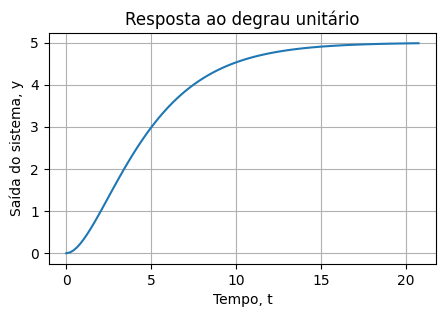

In [56]:
# Processo
s = ct.tf('s')
Gp = 5/((3*s+1)*(2*s+1))
print(Gp)
calcula_zpk(Gp)
caracteristica_2ordem(Gp)
resposta_degrau(Gp)

O sistema não irá oscilar frente a um degrau porque possui apenas polos reais. Além disso, o valor $\xi>1$ atesta esta conclusão. O gráfica acima mostra na prática que o sistema não oscila em malha aberta (isto é, sem o controlador).

In [49]:
# Fazendo a malha fechada de modo símbolico
Kc, s, tau, xi = sp.symbols('Kc, s, tau, xi')

# Controlador
Gc = Kc

# Processo
Gp_ = 5/((3*s+1)*(2*s+1))


# Malha fechada
G = Gc*Gp_/(1+Gc*Gp_)
G.expand().simplify()

5*Kc/(5*Kc + 6*s**2 + 5*s + 1)

A expressão G.expand().simplify() usando o SymPy é usada para expandir e simplificar uma expressão matemática representada pela variável G. Vou explicar o que cada parte faz:

* G representa uma expressão algébrica no SymPy.

* .expand() é um método que expande a expressão, ou seja, ele distribui e simplifica termos dentro de parênteses, realiza operações como multiplicação de polinômios e simplifica a expressão expandida.

* .simplify() é um método que simplifica ainda mais a expressão, removendo termos comuns e reduzindo a expressão ao seu formato mais simples.

O sistema em malha fechada deve ser colocado na forma padrão, tal que
$ G(s) = K/(\tau s^2 + 2\tau \xi s + 1)$.

Para colocar nesta forma, basta dividir por $1+5Kc$ o numerador e o denominador.

In [50]:
# Mostrando as operações do denominador
den = 6/(1+5*Kc)*s**2 + 5/(1+5*Kc) *s + 1
den

6*s**2/(5*Kc + 1) + 5*s/(5*Kc + 1) + 1

In [51]:
# Comparando termo a termo
tau = (6/(1+5*Kc))**0.5
tau

2.44948974278318*(1/(5*Kc + 1))**0.5

In [52]:
xi =  5/(1+5*Kc) / (2*tau)
xi.simplify()

1.02062072615966/((5*Kc + 1)*(1/(5*Kc + 1))**0.5)

In [79]:
# Calculando o valor de xi a partir de DR = 1/4
from sympy.solvers import solve
x = sp.symbols('x')
DR = sp.exp(-2*sp.pi*x/sp.sqrt(1-x*x))
solve(DR-1/4,x) # Use solve() para resolver equações algébricas simbolicamente.

[0.215453761966247, 1.24803314296506 + 0.896984282922112*I]

In [80]:
# Considerando apenas o valor real, xi = 0.215453761966247
k = solve(xi-0.215453761966247,Kc)[0]
k

4.28797676150498

In [87]:
# O valor de Kc é aproximadamente 4.30
# Vamos fechar a malha com este valor:

Gc = float(k)
G = Gc*Gp/(1+Gc*Gp) # relação entre y(s) e yset(s)
G = ct.minreal(G)
print('y/yset = ')
print(G)

2 states have been removed from the model
y/yset = 

        3.573
---------------------
s^2 + 0.8333 s + 3.74



zero =  []
polo =  [-0.41666667+1.88848339j -0.41666667-1.88848339j]
ganho = 0.955
Período natural = 0.517
Fator de amortecimento = 0.215
%Overshoot =  50.000
Decay ratio = 0.250
Tempo de pico = 1.664
Tempo de assentamento = 16.800


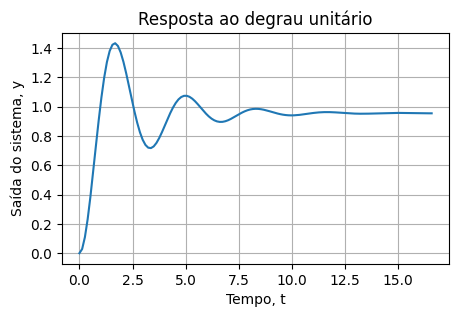

In [84]:
calcula_zpk(G)
caracteristica_2ordem(G)
resposta_degrau(G)

In [88]:
# Calculo do offset frente a um degrau unitário em yset
K = G.dcgain() # ganho estacionario da malha fechada
yset = 1.0
off_set = yset - K
off_set

0.04456351060359254

O sistema de controle em malha fechada em questão possui um controlador do tipo P (Proporcional) com os seguintes parâmetros: o ganho é de 0.955, e os polos do sistema estão em -0.4167+1.8885j e -0.4167-1.8885j. O período natural é de 0.517 unidades de tempo, e o fator de amortecimento é 0.215, o que indica que o sistema é subamortecido.

Além disso, o offset de 0.0446 indica um desvio constante entre a resposta do sistema e o valor desejado após a resposta ter se estabilizado. Essa resposta com um overshoot e offset pode ser relevante para sistemas em que essas características são aceitáveis ou desejadas, mas é importante considerar como esses parâmetros afetam o desempenho e a precisão do sistema em sua aplicação específica.

Em resumo, o sistema em malha fechada possui uma dinâmica de resposta transiente subamortecida, um alto percentual de overshoot e tempo de assentamento relativamente longo. Isso significa que o sistema pode levar um tempo considerável para atingir a estabilidade após uma mudança na referência (setpoint).